<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/codice_bpm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np # allows vectorized operations
import cupy as cp # fork of numpy
# allows vectorized operations on GPU
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation
# plot style parameters
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f7f9fc'

Prima di tutto definiamo delle funzioni di plot.

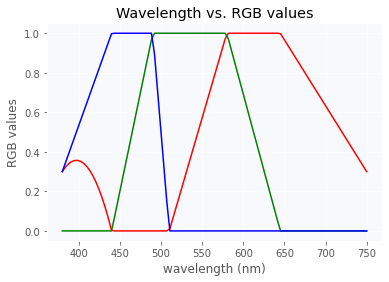

In [39]:
from matplotlib.colors import LinearSegmentedColormap
'''
To make more realistic plots we define a function
returning approzimated colormap from wavelength.
There is not a simple form for it, because of the
complex mechanisms of human vision and trichromy.
The physical model of colors mixing is achieved 
by summing values in RGB and clipping the results at 1.
'''
def wavelength_to_rgb(wavelength): # input in meters
    wavelength = wavelength*1e9 # nm
    '''
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    Additionally alpha value set to 0.5 outside range
    '''
    wl = float(wavelength)
    if wl < 380: wl = 380
    if wl > 750: wl = 750
    if wl >= 380 and wl <= 440:
        att = 0.3 + 0.7 * (wl - 380) / (440 - 380) # attenuation
        R, G, B = ((-(wl - 440) / (440 - 380)) * att), 0, (1.0 * att)
    elif wl >= 440 and wl <= 490:
        R, G, B = 0.0, ((wl - 440) / (490 - 440)), 1
    elif wl >= 490 and wl <= 510:
        R, G, B = 0.0, 1, (-(wl - 510) / (510 - 490))
    elif wl >= 510 and wl <= 580:
        R, G, B = ((wl - 510) / (580 - 510)), 1, 0
    elif wl >= 580 and wl <= 645:
        R, G, B = 1.0, (-(wl - 645) / (645 - 580)), 0
    elif wl >= 645 and wl <= 750:
        att = 0.3 + 0.7 * (750 - wl) / (750 - 645)
        R, G, B = (1.0 * att), 0, 0
    else:
        R, G, B = 0, 0, 0
    return cp.asarray([R, G, B])

wavelengths = np.linspace(380, 750, 100)*1e-9 # in meters
rgbs = np.stack([cp.asnumpy(wavelength_to_rgb(wl)) for wl in wavelengths])
plt.plot(1e9*wavelengths, rgbs[:, 0], "r-")
plt.plot(1e9*wavelengths, rgbs[:, 1], "g-")
plt.plot(1e9*wavelengths, rgbs[:, 2], "b-")
plt.xlabel("wavelength (nm)")
plt.ylabel("RGB values")
plt.title("Wavelength vs. RGB values")
plt.savefig("wl-rgb.pdf")
plt.show()


In [0]:
def wavelength_to_cmap(wavelength):
  R, G, B = wavelength_to_rgb(wavelength)
  cdict = {
        'red':  [[0.0,  0.0, 0.0],
                  [1.0,  R, R]],
        'green': [[0.0,  0.0, 0.0],
                  [1.0,  G, G]],
        'blue':  [[0.0,  0.0, 0.0],
                  [1.0,  B, B]]
            }
  return LinearSegmentedColormap('Cmap', segmentdata=cdict, N=256)
# default colormap is black screen with red light - similar to lab situation
default_wavelength = 651*1e-9 # meters
default_cmap = wavelength_to_cmap(default_wavelength)

In [0]:
# we define a function to plot 
def plot(Power, 
         figsize=(15, 15), width=15, unit="mm", cmap=default_cmap, 
         fig=None, ax=None
):
  if type(Power)==cp.core.core.ndarray:
    Power = cp.asnumpy(Power)
  if fig is None:
    fig, ax = plt.subplots(figsize=figsize)
  ax.grid(False)
  ax.set(xlabel=f"x ({unit})", ylabel=f"y ({unit})")
  im = ax.imshow(Power, 
      cmap=cmap, extent=[-width,width,-width,width], vmin=0, animated=True)
  return fig, ax, im

In [0]:
def save_animation(arrays, filename):
  ims = []
  fig, ax = plt.subplots(figsize=(15, 15))
  for n in range(arrays.shape[0]):
      fig, ax, im = plot(arrays[n], fig=fig, ax=ax)
      ims.append([im])

  ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                  repeat_delay=1000)

  Writer = animation.writers['ffmpeg']
  writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
  ani.save(filename, writer=writer)
  del ims
  plt.close()

Definiamo a questo punto le funzioni per propagare.

In [0]:
fft1, ifft1 = cp.fft.fft, cp.fft.ifft # cpu fft when in 1D
fft2, ifft2 = cp.fft.fft2, cp.fft.ifft2 # gpu fft when in 2D

In [0]:
def propagate(Field, k, 
  grid_setup=None, keep_memory=False, threshold=1e-14, check_energy=False):
  # k_square_grid is KX**2 + KY**2 in 2D and kx**2 in 1D
  nstepx, nstepz, deltaz, k_square_grid = grid_setup
  # establish which numerical lib to use
  if Field.ndim == 1:
    fft, ifft = fft1, ifft1
    fmm_shape = (nstepx, nstepz+1)
  elif Field.ndim == 2:
    fft, ifft = fft2, ifft2
    fmm_shape = (nstepx, nstepx, nstepz+1)
  if keep_memory:
    # keeps a record of field module at every step
    FieldModuleMemory = cp.zeros(shape=fmm_shape)
    FieldModuleMemory[..., 0] = cp.abs(InputField)

  ArgumentOfPropagator  = ((k*n0)**(-1)*k_square_grid)*(deltaz/2);             
  Propagator = cp.exp(1j*ArgumentOfPropagator)
  if check_energy:
    InputPower = cp.abs(Field)**2

  tstart = time.time()
  for step in range(nstepz):
      Field = ifft(fft(Field)*Propagator)
      if keep_memory:
        FieldModuleMemory[..., 1+step] = cp.abs(Field)
  print(f"Lasted {time.time()-tstart} seconds")

  if check_energy:
    OutputPower = cp.abs(Field)**2
    OutputTotalPower = cp.sum(OutputPower) # total power on output plane
    InputTotalPower = cp.sum(InputPower) # total power on input plane
    gap = (OutputTotalPower-InputTotalPower)/(OutputTotalPower+InputTotalPower)
    if gap > threshold:
      raise ValueError("Energy not conserved")

  if keep_memory:
      return Field, FieldModuleMemory
  else:
      return Field

In [0]:
def propagate_and_get_rgb(InputField, wavelength, grid=None, keep_memory=False):
  k = 2*np.pi/(wavelength)
  rgb = wavelength_to_rgb(wavelength)
  if keep_memory:
    OutputField, FieldModuleMemory = propagate(InputField, k, grid, keep_memory=True)
    IntMem = FieldModuleMemory**2
    if IntMem.ndim == 2:
      P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
    IntMemRGB = cp.stack((IntMem,)*3, axis=-1)/cp.max(IntMem)*rgb
  else:
    OutputField = propagate(InputField, k, grid)
  P = cp.abs(OutputField)**2
  if P.ndim == 1:
    P = cp.stack((cp.abs(OutputField)**2,)*100, axis=0)
  outRGB = cp.stack((P,)*3, axis=-1)/cp.max(P)*rgb
  if keep_memory:
    return (outRGB, IntMemRGB)
  else:
    return outRGB

# Fascio Gaussiano 2D

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength of red light
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 5; # computational length of sample    
Lx = 3e-2; # computational width of sample          
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.02*Lx # beam width of gaussian beam parameter


################## Computational Parameters #############
nstepx = 1024; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

grid_setup = (nstepx, nstepz, deltaz, KX**2+KY**2)

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# gaussian beam
InputField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2));

InputPower = cp.abs(InputField)**2

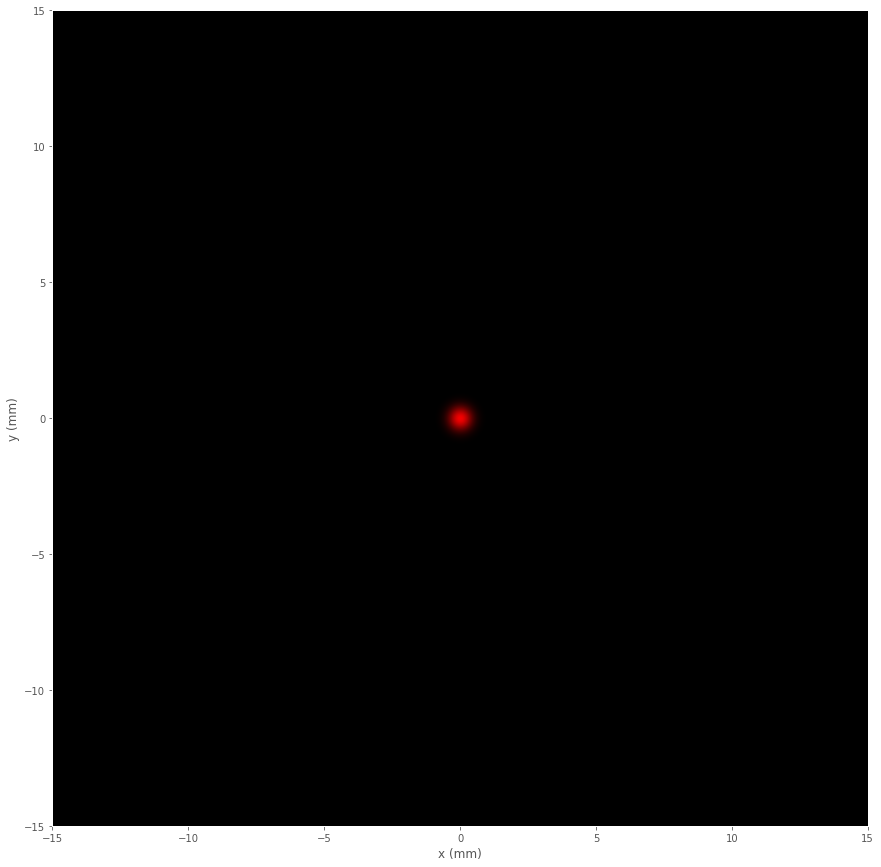

In [0]:
fig, ax, im = plot(InputPower, width=Lx*0.5e3)
fig.savefig("gaussianinputfield.pdf")
plt.show()
plt.close()

Lasted 0.02707505226135254 seconds


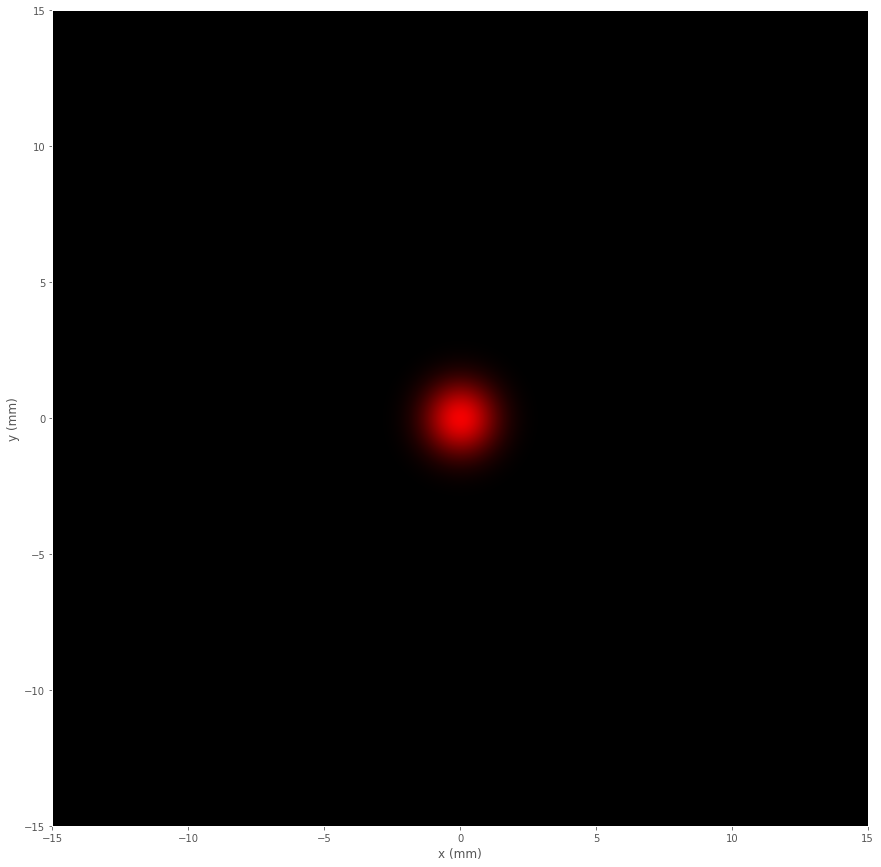

In [0]:
OutputField, FieldModuleMemory = propagate(InputField, k0, 
    grid_setup=grid_setup, keep_memory=True)
OutputPower = cp.abs(OutputField)**2
fig, ax, im = plot(OutputPower, width=Lx*0.5e3)
fig.savefig("gaussianoutputfield.pdf")
plt.show()
plt.close()

In [0]:
save_animation(cp.moveaxis(FieldModuleMemory**2, 2, 0), "gaussian_beam.mp4")

Propagation of a red (wider) and a blue (thiner) beam.

Lasted 0.02524733543395996 seconds
Lasted 0.019706010818481445 seconds


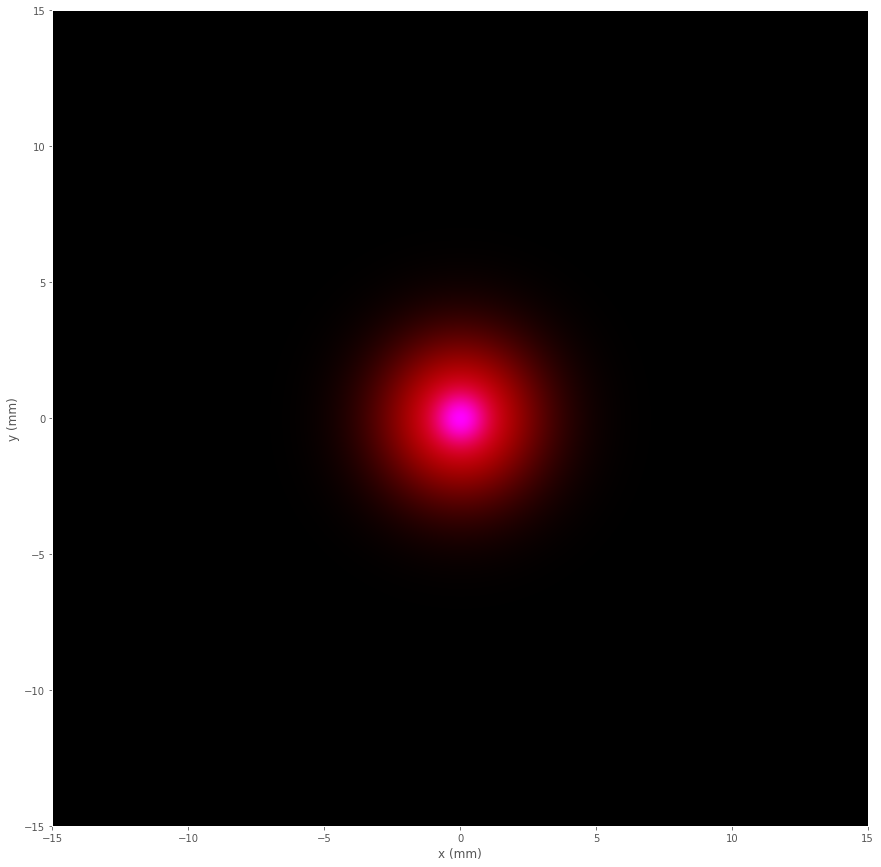

In [0]:
InputField1 = cp.sqrt(Ip)*cp.exp(-((X)**2+(Y)**2)/(49*w0**2)); #7x larger
InputField2 = cp.sqrt(Ip)*cp.exp(-((X)**2+(Y)**2)/(w0**2));

RedPower = propagate_and_get_rgb(InputField1, 0.645e-6, grid=grid_setup)
BluePower = propagate_and_get_rgb(InputField, 0.44e-6, grid=grid_setup)
fig, ax, im = plot(RedPower + BluePower) #purple point with red cirle 
# red + blue = purple
fig.savefig("redbluegaussianbeam.pdf")
plt.show()
plt.close()

In [0]:
# we evaluate beam widths (FWHM) as the 2nd moment of a gaussian function

def get_widths(FieldModuleMemory):
  # extends grids X and Y to a third axis
  # in order to make possible multiplying by FieldModuleMemory
  _X = cp.stack((X,)*(nstepz+1), axis=-1)
  _Y = cp.stack((Y,)*(nstepz+1), axis=-1)

  norms = cp.sum(FieldModuleMemory, axis=(0, 1))
  widths = cp.sqrt(np.sum((_X**2+_Y**2)*FieldModuleMemory, axis=(0, 1))/norms)
  return widths

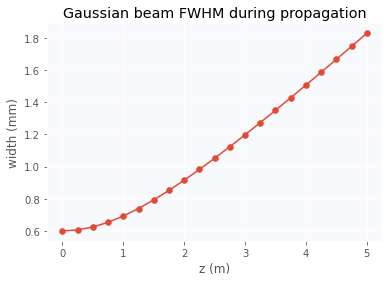

In [0]:
z, widths = cp.asnumpy(z), cp.asnumpy(get_widths(FieldModuleMemory))
plt.scatter(z, 1000*widths)
z0 = k0*w0**2/2 # Rayleigh's width
plt.plot(z, 1000*w0*np.sqrt(1+z**2/z0**2))
plt.xlabel("z (m)")
plt.ylabel("width (mm)")
plt.title("Gaussian beam FWHM during propagation")
plt.savefig("gaussianbeamfwhm.pdf")
plt.show()

# Diffraction Grating

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                       
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 0.12; # computational length of sample    
Lx = 40e-3; # computational width of sample          

w0 = 0.25e-3 # beam width of gaussian beam parameter
dist = 5e-6 # distance between slits
width = 1e-6 # width of slits

################## Computational Parameters #############
nstepx = 2024*32; # number of transverse grid points
nstepz = 1024; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array
##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*cp.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

grid_setup = (nstepx, nstepz, deltaz, kx**2)

In [0]:
PlaneInputField = 0*x

N = 100
PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x)**20/(width**20)))
for n in range(1, N+1):
  PlaneInputField += cp.sqrt(Ip)*(cp.exp(-(x-n*dist)**20/(width**20))+cp.exp(-(x+n*dist)**20/(width**20)))

PlaneInputField = PlaneInputField * cp.exp(-(x)**2/(w0**2))

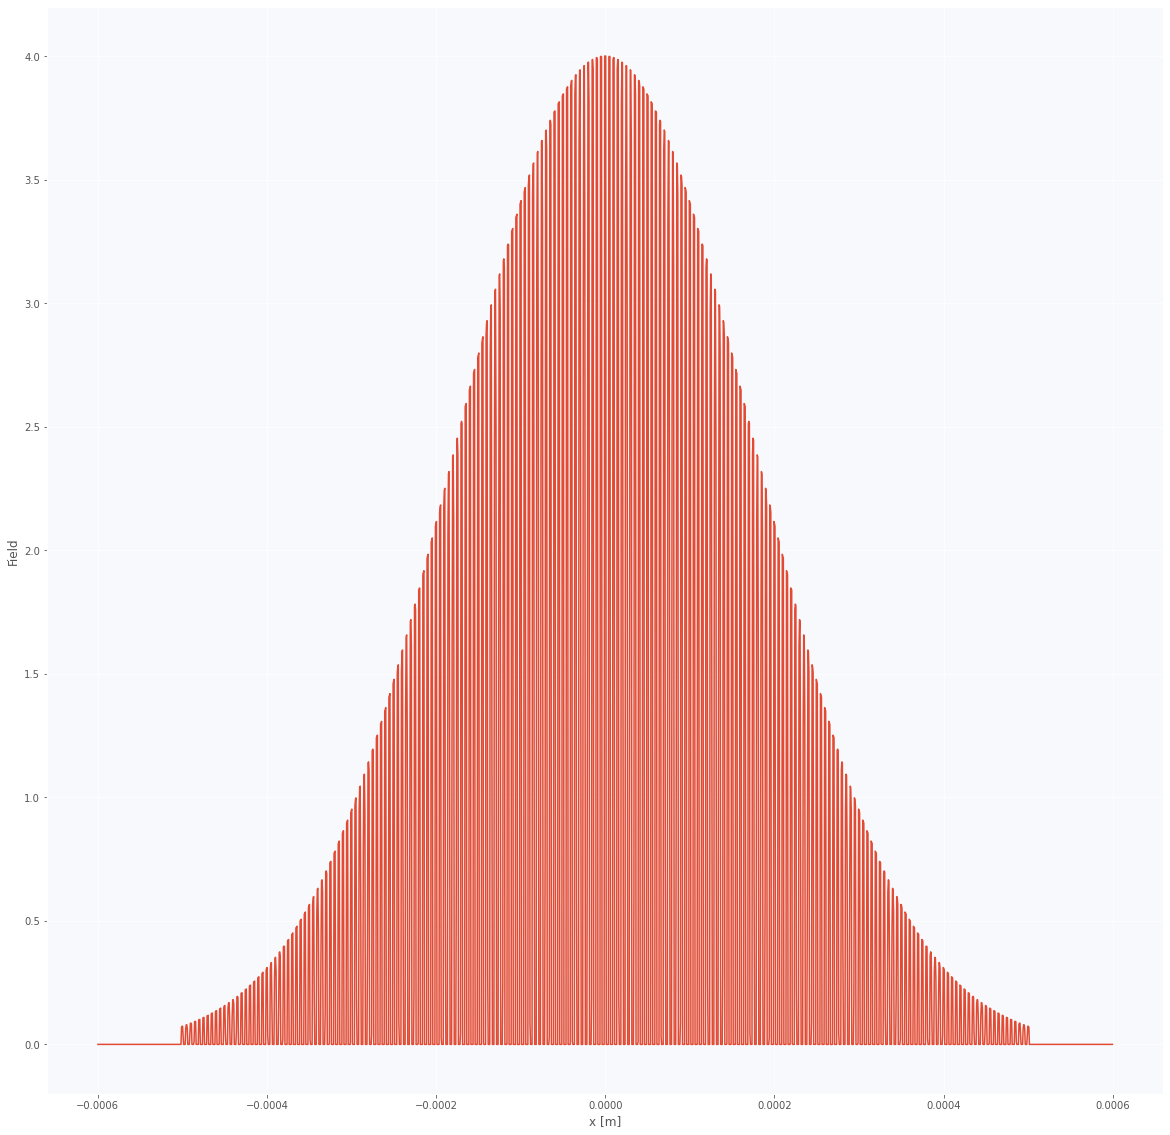

In [0]:
fig, ax = plt.subplots(figsize=(20, 20))
x_range = cp.abs(x)<6e-4
ax.plot(cp.asnumpy(x[x_range]), cp.asnumpy(PlaneInputField[x_range]))
ax.set(xlabel="x [m]", ylabel="Field")
fig.savefig("gratinginputfield.pdf")
plt.show()
plt.close()

Lasted 2.3564400672912598 seconds
Lasted 0.987579345703125 seconds


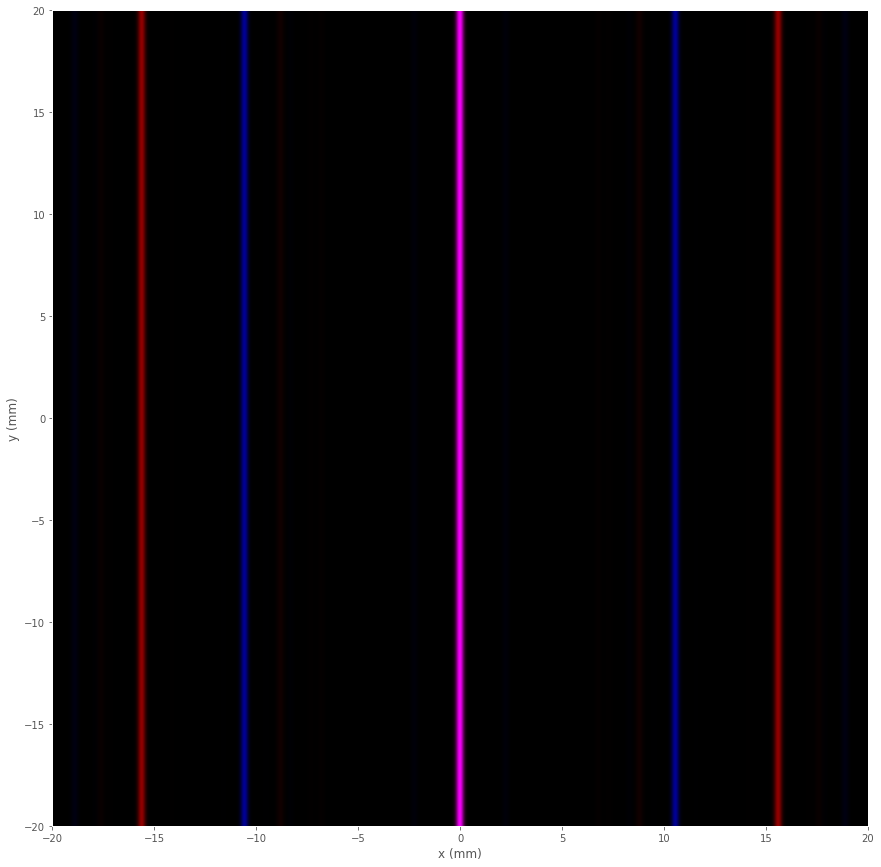

In [0]:
Red = propagate_and_get_rgb(PlaneInputField, 0.65e-6, grid=grid_setup)
Blue = propagate_and_get_rgb(PlaneInputField, 0.44e-6, grid=grid_setup)

fig, ax, im = plot((Red+Blue), width=20)
fig.savefig("redbluegrating.pdf")
plt.show()
plt.close()

Come previsto i massimi più visibili sono 3 in totale, uno al centro e gli altri due più lontani ma simmetrici.

Lasted 1.01460862159729 seconds
Lasted 0.9877116680145264 seconds


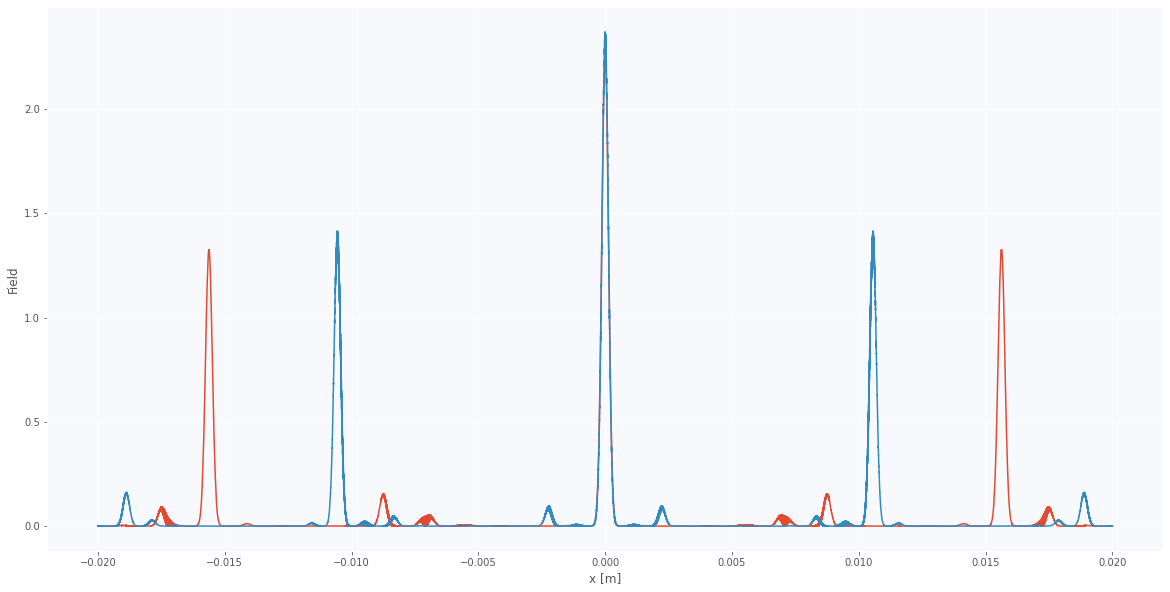

In [0]:
OutputField = propagate(PlaneInputField, k0, grid_setup=grid_setup)
intensity = cp.abs(OutputField)**2
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))
OutputField = propagate(PlaneInputField, 2*np.pi/0.44e-6, grid_setup=grid_setup)

intensity = cp.abs(OutputField)**2
ax.plot(cp.asnumpy(x), cp.asnumpy(intensity))
ax.set(xlabel="x [m]", ylabel="Field")
fig.savefig("peaksgrating.pdf")
plt.show()
plt.close()

Per il rosso, i massimi sono distanti circa 16 mm dal centro, e lo schermo è lontano 120mm dal reticolo: $\sin(\theta) = 16/120 = 0.13$.<br>
La distanza tra le slits vale 5 micron, a fronte di una lunghezza d'onda di 0.65 micron. Dunque $d/\lambda = 0.65/5 = 0.13 = \sin(\theta)$ come previsto.

Valutiamo il potere risolutivo.

Lasted 1.0158767700195312 seconds
Lasted 1.0130035877227783 seconds


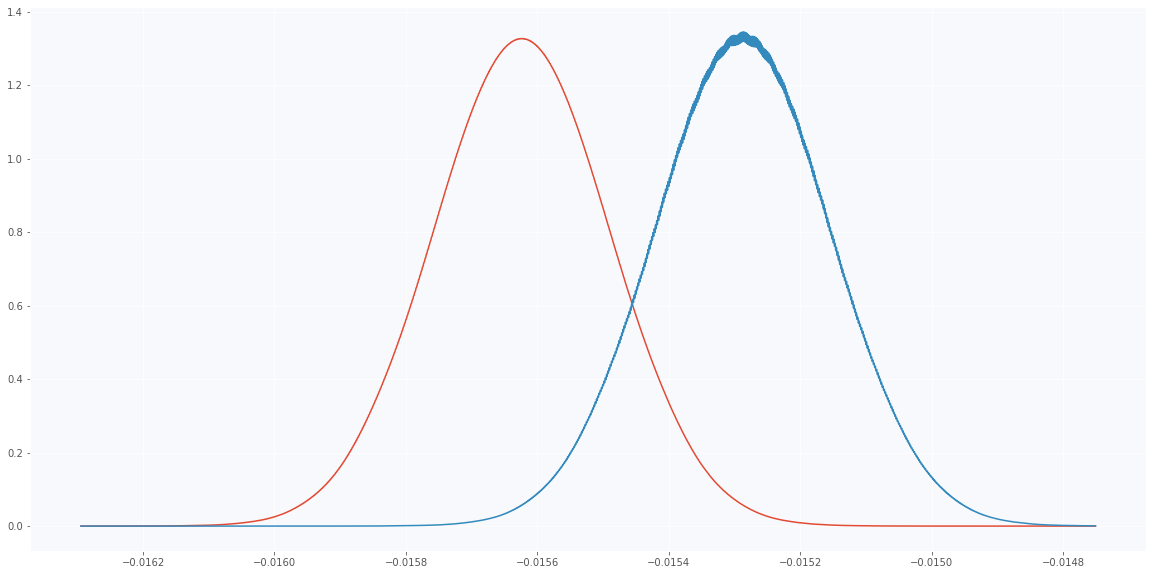

In [0]:
OutputField = propagate(PlaneInputField, 2*cp.pi/0.651e-6, grid_setup=grid_setup)
intensity1 = cp.abs(OutputField)**2

OutputField = propagate(PlaneInputField, 2*cp.pi/0.637e-6, grid_setup=grid_setup)
intensity2 = cp.abs(OutputField)**2

xrange = cp.arange(6000, 8500)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(cp.asnumpy(x[xrange]), cp.asnumpy(intensity1[xrange]))
ax.plot(cp.asnumpy(x[xrange]), cp.asnumpy(intensity2[xrange]))
fig.savefig("taylor.pdf")
plt.show()
plt.close()

Le lunghezze d'onda hanno 14nm di differenza. Il potere risolutivo dunque vale 651/14 = 47.

Lasted 1.0106101036071777 seconds
Lasted 1.008086919784546 seconds
Lasted 1.0170490741729736 seconds
Lasted 0.9927933216094971 seconds
Lasted 1.0217580795288086 seconds
Lasted 1.0082886219024658 seconds
Lasted 1.0047061443328857 seconds
Lasted 1.0115461349487305 seconds
Lasted 1.011768102645874 seconds
Lasted 0.9939620494842529 seconds
Lasted 1.0022099018096924 seconds
Lasted 1.0137553215026855 seconds
Lasted 1.045393466949463 seconds
Lasted 0.9951329231262207 seconds
Lasted 0.9940075874328613 seconds
Lasted 0.9777884483337402 seconds
Lasted 0.9794483184814453 seconds
Lasted 0.9913005828857422 seconds
Lasted 0.995901346206665 seconds
Lasted 1.007244348526001 seconds
Lasted 1.0192770957946777 seconds
Lasted 1.0367846488952637 seconds
Lasted 1.0499274730682373 seconds
Lasted 1.0211281776428223 seconds
Lasted 1.0428459644317627 seconds
Lasted 1.0331060886383057 seconds
Lasted 1.054002285003662 seconds
Lasted 1.013225793838501 seconds
Lasted 0.9926996231079102 seconds
Lasted 1.001379966735

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Lasted 1.0229804515838623 seconds


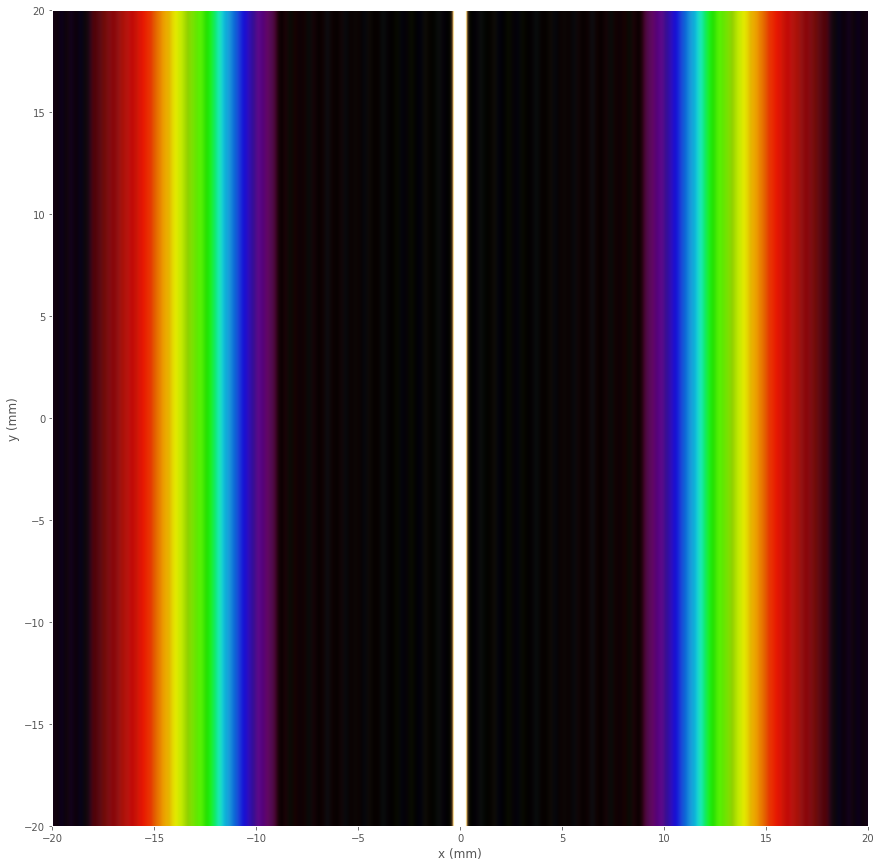

In [0]:
output = cp.zeros(Red.shape)
wavelengths = np.linspace(380, 750, 40) # light with 7 colors
for wl in wavelengths:
 output += propagate_and_get_rgb(PlaneInputField, wl*1e-9, grid=grid_setup)

fig, ax, im = plot(output, width=20)
fig.savefig("rainbow.pdf")
plt.show()
plt.close()

# Lens

In [47]:
!wget https://github.com/raeubaen/ml/blob/master/refractiveindex.xlsx?raw=true -O glass_n.xlsx
import pandas
df = pandas.read_excel("glass_n.xlsx", names=["wl", "n"])
df.wl = df.wl*1e-6

--2020-05-29 15:01:17--  https://github.com/raeubaen/ml/blob/master/refractiveindex.xlsx?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/raeubaen/ml/raw/master/refractiveindex.xlsx [following]
--2020-05-29 15:01:17--  https://github.com/raeubaen/ml/raw/master/refractiveindex.xlsx
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/raeubaen/ml/master/refractiveindex.xlsx [following]
--2020-05-29 15:01:18--  https://raw.githubusercontent.com/raeubaen/ml/master/refractiveindex.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK


In [48]:
df

,wl,n
0,2.100000e-07,1.538358
1,2.174000e-07,1.530846
2,2.251000e-07,1.524079
3,2.330000e-07,1.518042
4,2.412000e-07,1.512572
5,2.497000e-07,1.507610
6,2.585000e-07,1.503101
7,2.676000e-07,1.498999
8,2.770000e-07,1.495263
9,2.868000e-07,1.491822


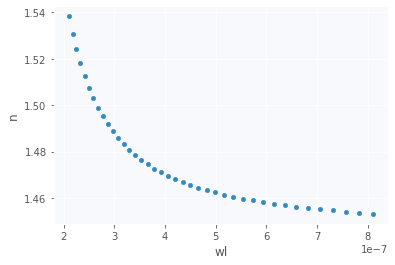

In [49]:
df.plot.scatter("wl", "n")

Il fit può essere utile per avere l'indice di rifrazione per ogni colore, ma in realtà i circa 30 punti da wl>0.3 in poi bastano per comporre luce bianca.

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


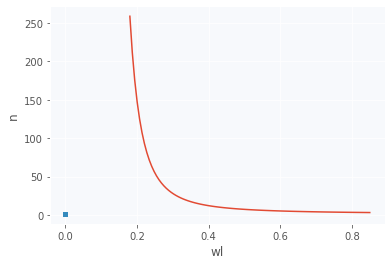

In [50]:
from scipy.optimize import curve_fit
def get_n(wl, a, b, c):
  return a*(np.exp(b/wl)-1)+c
(a, b, c), pcov = curve_fit(get_n, df.wl, df.n)

wl = np.linspace(0.18, 0.85, 100)
n = get_n(wl, a, b, c)

df.plot.scatter("wl", "n")
plt.plot(wl, n)

In [0]:
################### Physical Parameters  ########################
Ip = 4**2; # peak intensity               
Ib = 1.0; # background illumination                             
Lambda = 0.651e-6; # wavelength
k0 = 2*np.pi/Lambda; # vacuum wavevector                 
n0 = 1; # background index of refraction      
Lz = 2; # computational length of sample    
Lx = 30e-3; # computational width of sample          
Chirp = -0.0*6*230000.0; # input linear chirp parameter         
h = 0*0.67e-3;
xshift = +h/2; # input position on x axis               
w0 = 0.5e-3 # beam width of gaussian beam parameter

fl = 0.4; # focal length

################## Computational Parameters #############
nstepx = 1024; # number of transverse grid points
nstepz = 20; # number of longitudinal propagation steps

deltax = Lx/nstepx;
deltaz = Lz/nstepz; # resolution in the z direction, IMPORTANT
deltaf = 1/Lx; # spatial frequency step

In [0]:
##########################  GENERAL GRID SET-UP  ##########################

z = cp.arange(0, Lz+deltaz, deltaz) # z array            
x = -Lx/2 +(cp.arange(0, nstepx, 1))*deltax; # x array               

X, Y = cp.meshgrid(x,x); # x and y grid

##########################  Dispersive Step Setup #########################
# this is to get rid of fftshifts and the sort

ntx = 0;             
kx = cp.zeros(nstepx)                                          
for nn in range(nstepx):
    ikx = nn - ntx;
    kx[nn] = 2*np.pi*deltaf*ikx;
    if nn + 1 - nstepx/2 == 0 :
      ntx = nstepx;

KX, KY = cp.meshgrid(kx, kx);

grid_setup = (nstepx, nstepz, deltaz, KX**2+KY**2)

In [0]:
####################### INPUT FIELDS DEFINITION  #########################
# field outside of a lens 
Phase = cp.exp(1j*k0/(2*fl)*(X**2+Y**2))
InputField = cp.sqrt(Ip)*cp.exp(-(X**2+Y**2)/(w0**2)) * Phase

In [56]:
outRGB, IntMemRGB = propagate_and_get_rgb(InputField, 0.651e-6, grid=grid_setup, keep_memory=True)

Lasted 0.04180288314819336 seconds


(<Figure size 1080x1080 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7f94b23eff60>)

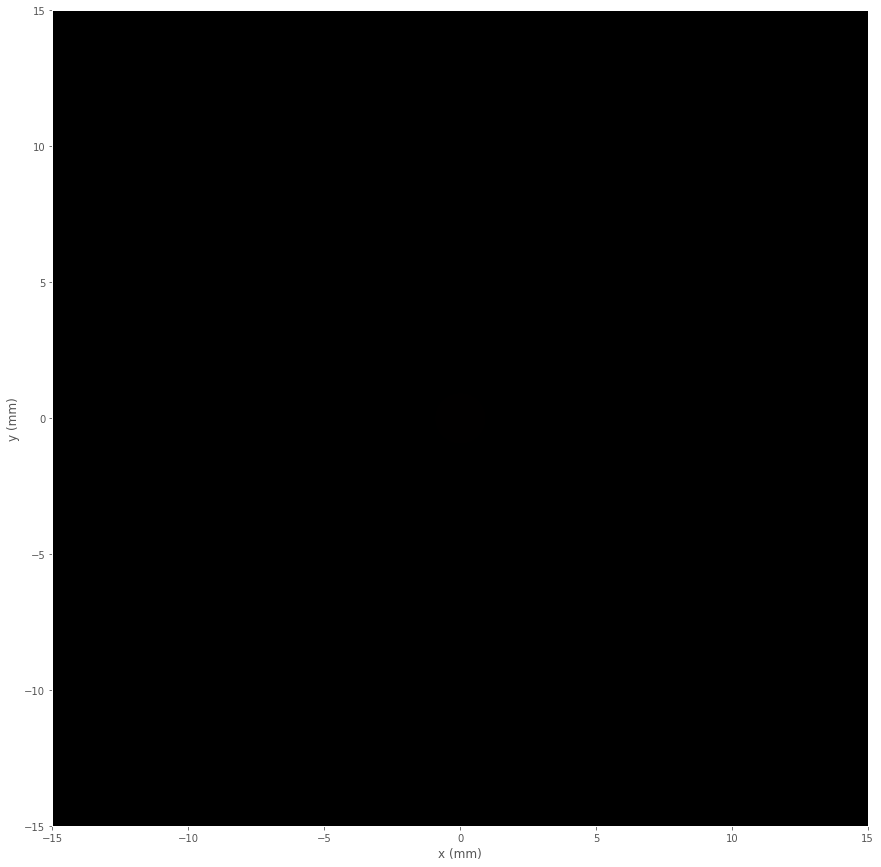

In [63]:
plot(IntMemRGB[..., 20, :])